In [5]:
import pandas as pd
import numpy as np
import traffic
from traffic.core import Traffic
from traffic.data import opensky
from traffic.data import airports
from traffic.data import aircraft
import matplotlib.pyplot as plt
import datetime
#import tdqm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

## Trajs Preprocessing and Classification (Takeoff & Pushback)

In [6]:
airport_str = 'LSZH'
path = '/home/wate/osn24_agps/'
trajs_filenames = ['LSZH_MAY24.pkl', 'LSZH_JUN24.pkl', 'LSZH_JUL24.pkl', 'LSZH_AUG24.pkl', 'LSZH_SEP24.pkl']
trajs_filenames = ['LSZH_MAY24.pkl']
#trajs_filenames = ['LSZH_test.pkl'] 

In [7]:
def get_df_movements(gnd_trajs):

    # Group by 'flight_id'
    grouped = gnd_trajs.query('takeoffRunway != ""').groupby('flight_id')
    
    # Create a new DataFrame df_movements to store the summarized data
    df_movements = pd.DataFrame()
    
    # Extract the required information
    df_movements['flight_id'] = grouped['flight_id'].first()
    df_movements['callsign'] = grouped['callsign'].first()
    df_movements['isPushback'] = grouped['isPushback'].first()
    df_movements['startPushback'] = grouped['startPushback'].first()
    df_movements['startTaxi'] = grouped['startTaxi'].first()
    df_movements['lineupTime'] = grouped['lineupTime'].first()
    df_movements['taxiDuration'] = grouped['taxiDuration'].first()
    df_movements['taxiDistance'] = grouped['taxiDistance'].first()
    df_movements['takeoffRunway'] = grouped['takeoffRunway'].first()
    df_movements['typecode'] = grouped['typecode'].first()
    df_movements['MESengine'] = grouped['MESengine'].first()
    df_movements['MESapu'] = grouped['MESapu'].first()
    df_movements['normTAXIengine'] = grouped['normTAXIengine'].first()
    df_movements['extAGPSapu'] = grouped['extAGPSapu'].first()
    df_movements['extAGPStug'] = grouped['extAGPStug'].first()
    
    # Reset index to get a clean DataFrame
    df_movements = df_movements.reset_index(drop=True)

    return df_movements

    

In [ ]:
import agps_funs
import agps_config
from agps_funs import alternative_pushback_detection, takeoff_detection, normalTaxiFuel, extAGPSTaxiFuel
from agps_config import get_Stands_LSZH

# Number of CPUs
max_workers=50

# Load taxi-in, push-out stand areas for LSZH
stands = get_Stands_LSZH()

i = 0
while i < len(trajs_filenames):

    # Load trajs
    gnd_trajs = Traffic.from_file(trajs_filenames[i])

    # Preprocessing
    gnd_trajs = gnd_trajs.query('altitude<4000 or onground')
    gnd_trajs = gnd_trajs.assign_id().resample('1s').eval(max_workers=max_workers, desc='resampling')
    gnd_trajs = gnd_trajs.aircraft_data()
    gnd_trajs = gnd_trajs.cumulative_distance().eval(max_workers=max_workers, desc='cumdist')

    # Runway classification
    gnd_trajs = gnd_trajs.iterate_lazy().pipe(takeoff_detection, 'lszh').eval(max_workers=max_workers, desc='Takeoff Detection')

    # Pushback classification
    stands = get_Stands_LSZH()
    gnd_trajs = gnd_trajs.iterate_lazy().pipe(alternative_pushback_detection, stands).eval(max_workers=max_workers, desc='Pushback Detection')

    # Fuel Calculation
    gnd_trajs = gnd_trajs.iterate_lazy().pipe(normalTaxiFuel).eval(max_workers=max_workers, desc='Taxi Fuel')
    gnd_trajs = gnd_trajs.iterate_lazy().pipe(extAGPSTaxiFuel).eval(max_workers=max_workers, desc='External AGPS')
    
    # Get df_movements
    df_movements = get_df_movements(gnd_trajs)
    
    # Save to pickle
    save_filename = path + trajs_filenames[i].replace('.pkl', '_df_movements.pkl')
    df_movements.to_pickle(save_filename)

    i += 1

resampling:   0%|          | 0/34293 [00:00<?, ?it/s]

cumdist:   0%|          | 0/34293 [00:00<?, ?it/s]

Takeoff Detection:   0%|          | 0/34293 [00:00<?, ?it/s]

Pushback Detection:   0%|          | 0/34293 [00:00<?, ?it/s]

***
# Some stats
***

In [11]:
# Group by TO_runway and calculate mean and std
overview = df_movements.groupby('takeoffRunway')['taxiDuration'].agg(['count', 'mean', 'std']).reset_index()

# Display the result
overview

TypeError: float() argument must be a string or a real number, not 'Timedelta'

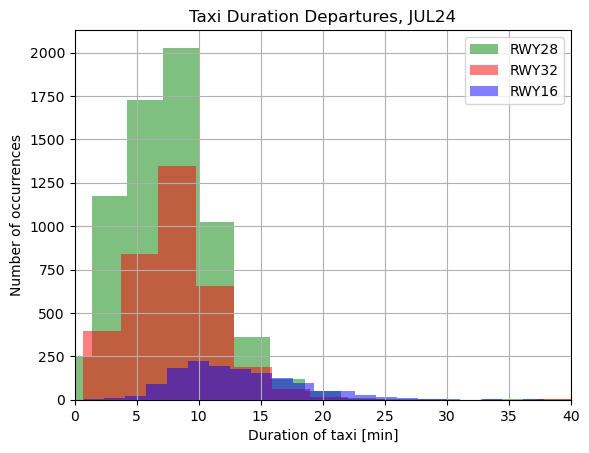

In [14]:
import matplotlib.pyplot as plt

# Plotting histograms
plt.hist((df_movements.query('takeoffRunway=="28"').taxiDuration.dt.total_seconds()/60), 
         bins=30, color='g', alpha=0.5, label='RWY28')
plt.hist((df_movements.query('takeoffRunway=="32"').taxiDuration.dt.total_seconds()/60), 
         bins=30, color='r', alpha=0.5, label='RWY32')
plt.hist((df_movements.query('takeoffRunway=="16"').taxiDuration.dt.total_seconds()/60), 
         bins=30, color='b', alpha=0.5, label='RWY16')

# Adding grid, legend, labels, and title
plt.xlim((0,40))
plt.grid()
plt.legend(loc='upper right')
plt.xlabel("Duration of taxi [min]")
plt.ylabel('Number of occurrences')
plt.title('Taxi Duration Departures, JUL24')

# Display the plot
plt.show()


***
# Some illustrations
***

### Check runway classification

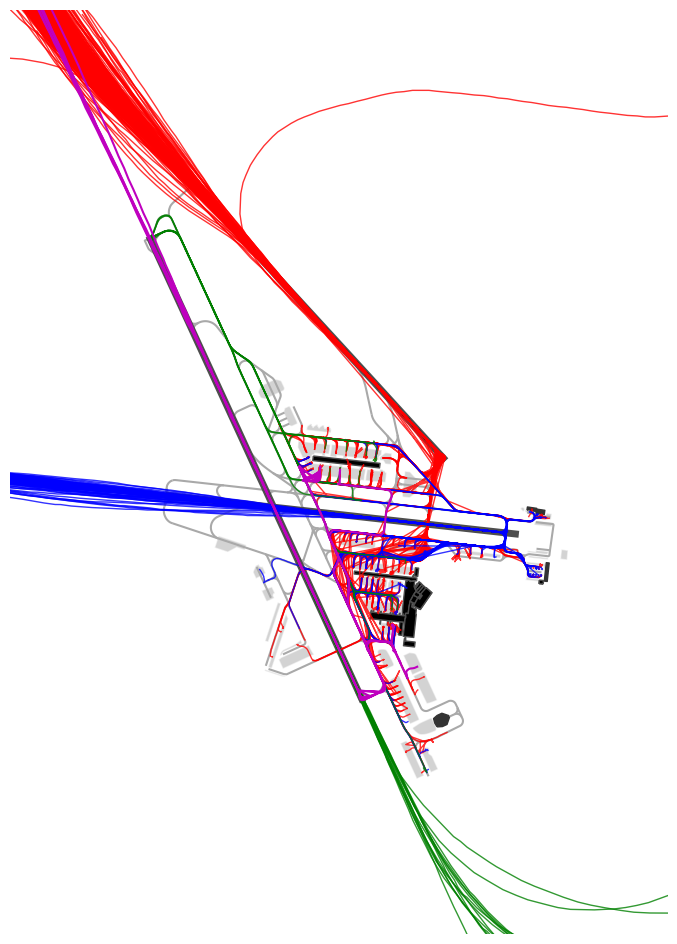

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
ax.spines["geo"].set_visible(False)

# gnd_trajs['XAFTY_016'].plot(ax=ax, color='r')

gnd_trajs[df_movements.query('takeoff_runway == "32"').flight_id.values].plot(ax=ax, color='r')
gnd_trajs[df_movements.query('takeoff_runway == "28"').flight_id.values].plot(ax=ax, color='b')
gnd_trajs[df_movements.query('takeoff_runway == "16"').flight_id.values].plot(ax=ax, color='g')
gnd_trajs[df_movements.query('takeoff_runway == "34"').flight_id.values].plot(ax=ax, color='m')
# gnd_trajs[df_movements.query('TO_runway == "10"').flight_id.values].plot(ax=ax, color='y')

ax.set_extent((8.5230, 8.5855, 47.4904, 47.4306))

### Plot trajectories to pdf

In [81]:
from matplotlib.backends.backend_pdf import PdfPages
import sys
import importlib
sys.path.append('/home/wate/osn24_agps')
from agps_config import AC2CONSIDER

#flt_ids = df_movements.query('taxiDuration > datetime.timedelta(minutes=30)').flight_id
# flt_ids = df_movements.query('taxiDistance > 3').flight_id
flt_ids = df_movements.flight_id

df_filtered = df_movements[df_movements['flight_id'].isin(flt_ids)]
df_filtered = df_filtered[df_filtered['typecode'].isin(AC2CONSIDER)]
df_filtered

# Number of pages and trajectories per page
n_Pages = 20
trajsPerPage = 5
colors = ['r', 'b', 'g', 'y', 'c']

# Sample all flight_id once (n_Pages * trajsPerPage)
total_sample_size = n_Pages * trajsPerPage
sample = df_filtered.sample(n=total_sample_size, replace=False)

# Access gnd_trajs once (access is slow due to its size)
trajs_tmp = gnd_trajs[sample.flight_id.values]

# Split the sample into smaller chunks for each page
sample_chunks = [sample[i:i + trajsPerPage] for i in range(0, len(sample), trajsPerPage)]


with PdfPages('/home/wate/osn24_agps/check_flights.pdf') as pdf:

    # Iterate over each chunk for plotting
    for repeat, sample_chunk in enumerate(sample_chunks):
        fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=EuroPP()))
        airports[airport_str].plot(ax, by='aeroway', aerodrome=dict(alpha=0))
        ax.spines["geo"].set_visible(False)
        ax.set_extent((8.5230, 8.5855, 47.4904, 47.4306))

        # Plot runway geometries once
        for rwy in rwys:
            ax.plot(*rwy.exterior.xy, transform=data_proj, color='m')

        # Plot the trajectories for the current chunk
        for i, (index, flt) in enumerate(sample_chunk.iterrows()):
            
            # Plot the entire trajectory
            trajs_tmp[flt.flight_id].plot(ax=ax, color=colors[i], label=f'{flt.flight_id} RWY {flt.takeoffRunway} d={round(flt.taxiDistance,2)}')

            # Highlight taxi part
            trajs_tmp[flt.flight_id].between(flt.startTaxi, flt.lineupTime).plot(ax=ax, color=colors[i], linewidth=4)

            # Mark pushback part if applicable
            if flt.isPushback:
                trajs_tmp[flt.flight_id].between(flt.startPushback, flt.startTaxi).plot(ax=ax, color='m', linewidth=4)

        plt.legend(loc='upper right')
        pdf.savefig()  # Save the current page into the PDF
        plt.close()  # Close the plot to free memory



[W 2024-09-05 20:46:37,009.009 cartes.osm.overpass] aeroway=deicing_pad not in stylesheet, hence ignored
[W 2024-09-05 20:46:37,184.184 cartes.osm.overpass] navigationaid=als not in stylesheet, hence ignored
[W 2024-09-05 20:46:37,202.202 cartes.osm.overpass] navigationaid=rgl not in stylesheet, hence ignored
[W 2024-09-05 20:46:37,202.202 cartes.osm.overpass] navigationaid=txc not in stylesheet, hence ignored
[W 2024-09-05 20:46:37,203.203 cartes.osm.overpass] navigationaid=txe not in stylesheet, hence ignored
[W 2024-09-05 20:46:37,203.203 cartes.osm.overpass] navigationaid=vasi not in stylesheet, hence ignored
[W 2024-09-05 20:46:41,533.533 cartes.osm.overpass] aeroway=deicing_pad not in stylesheet, hence ignored
[W 2024-09-05 20:46:41,708.708 cartes.osm.overpass] navigationaid=als not in stylesheet, hence ignored
[W 2024-09-05 20:46:41,727.727 cartes.osm.overpass] navigationaid=rgl not in stylesheet, hence ignored
[W 2024-09-05 20:46:41,727.727 cartes.osm.overpass] navigationaid=tx